In [2]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs
import torch.nn as nn
import torch.nn.functional as F
assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
class LeNet(nn.Module):
    def __init__(self, num_channels=1):
        super(LeNet,self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1),
        )
        self.classifier = nn.Linear(in_features=4*4*64, out_features=10)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    callbacks = None
    ) -> None:
    model.train()

    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [6]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    extra_preprocess = None) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        if extra_preprocess is not None:
            for preprocess in extra_preprocess:
                inputs = preprocess(inputs)
        
        targets = targets.cuda()

        # Inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

In [7]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [8]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

NN_ROUND = lambda out_shift : (0x1 << out_shift) >> 1

In [9]:
checkpoint_url = './models/LeNet_best.pth'
checkpoint = torch.load(checkpoint_url, map_location="cpu")
model = LeNet(3).cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint)
recover_model = lambda : model.load_state_dict(checkpoint)

=> loading checkpoint './models/LeNet_best.pth'


In [10]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), 
                (0.2023, 0.1994, 0.2010))
    ]),
    "test": Compose([ToTensor(),
                Normalize((0.4914, 0.4822, 0.4465), 
                    (0.2023, 0.1994, 0.2010))
    ])
}
dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="data/cifar10",
        train=(split == "train"),
        download=True,
        transform=transforms[split],
    )
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=32,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
    )

Files already downloaded and verified
Files already downloaded and verified


In [11]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/313 [00:00<?, ?it/s]

fp32 model has accuracy=78.21%
fp32 model has size=0.34 MiB


In [12]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

In [13]:
#http://www.kaizou.org/2023/05/quantization-fixed-point
def scale_quantize(fp_tensor, bitwidth=8, signed = True, dtype=torch.int8) -> torch.Tensor:
    """Convert a number to a FixedPoint representation
        The representation is composed of a mantissa and an implicit exponent expressed as
        a number of fractional bits, so that:
        fp_tensor ~= mantissa . 2 ** -frac_bits
        The mantissa is an integer whose bitwidth and signedness are specified as parameters.
    Args:
        fp_tensor: the source number or array
        from
            fp_tensor = (quantized_tensor) * scale
        we have,
            quantized_tensor = int(round(fp_tensor / scale))
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
        [int] number of fractional bits
    """
    assert(fp_tensor.dtype == torch.float)
    
    # Single Precision Floating Point (fp32) has 23 bits of mantissa, 8 bits of exponent, and 1 bit of sign
    # Mantissa bits: -1 is for sign bit
    mantissa_bits = bitwidth - 1 if signed else bitwidth
    
    int_bit = int(torch.log2(torch.abs(fp_tensor).max()).ceil())
    frac_bits = mantissa_bits - int_bit

    scale = 2. ** frac_bits
    scaled_tensor = fp_tensor * scale
    # Step 2: round the floating value to integer value
    qscaled_tensor = torch.round(scaled_tensor)
    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    mantissa_min = -2 ** mantissa_bits if signed else 0
    mantissa_max = 2 ** mantissa_bits - 1
    quantized_tensor = torch.clamp(qscaled_tensor, mantissa_min, mantissa_max).to(dtype)
    
    return quantized_tensor, frac_bits

In [14]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor, frac_bits = scale_quantize(test_tensor, bitwidth=bitwidth, signed=False, dtype=torch.int8)
    _quantized_test_tensor = _quantized_test_tensor.type(torch.int8)
    scale = 2. ** - frac_bits
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float())
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    # assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.25
* Test passed.


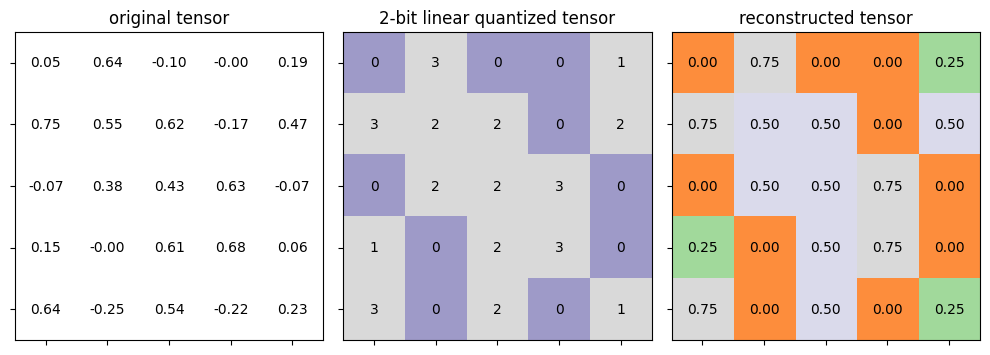

In [15]:
test_linear_quantize()

In [16]:
def scale_quantize_feature(fp_tensor, bitwidth, signed=True):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale
        [int] fraction bits
    """
    quantized_tensor, frac_bits = scale_quantize(fp_tensor, bitwidth, signed=signed)
    scale = 2. ** frac_bits
    return quantized_tensor, scale, frac_bits

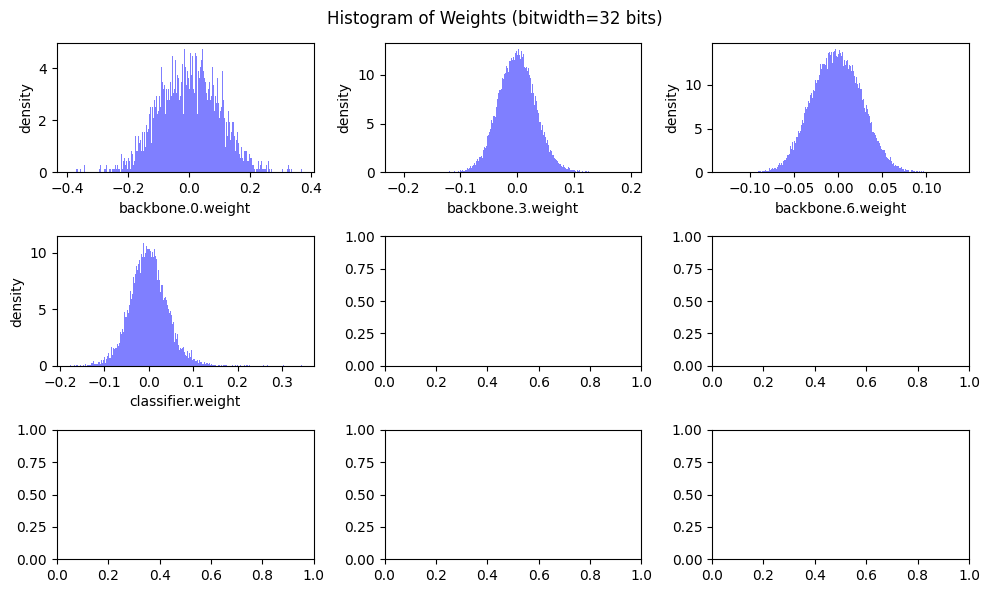

In [17]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

In [18]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

In [19]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor, _ = scale_quantize(tensor, bitwidth)
    return quantized_tensor, scale, 0

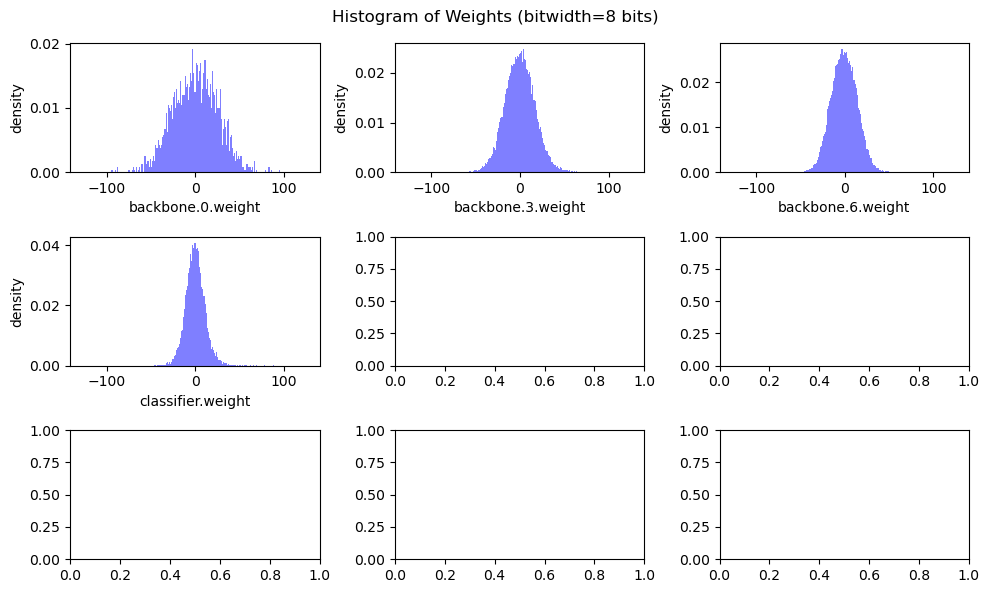

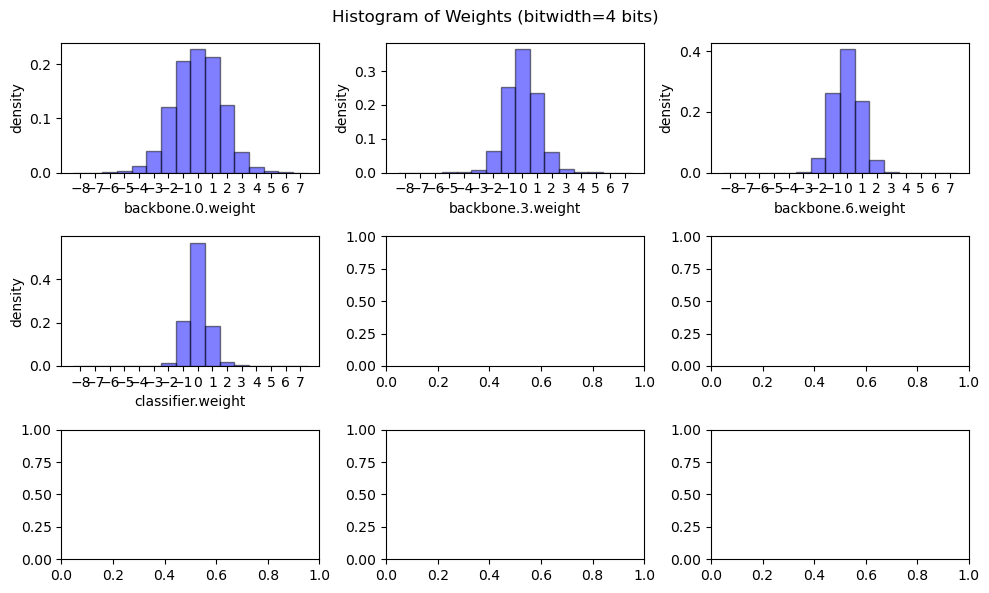

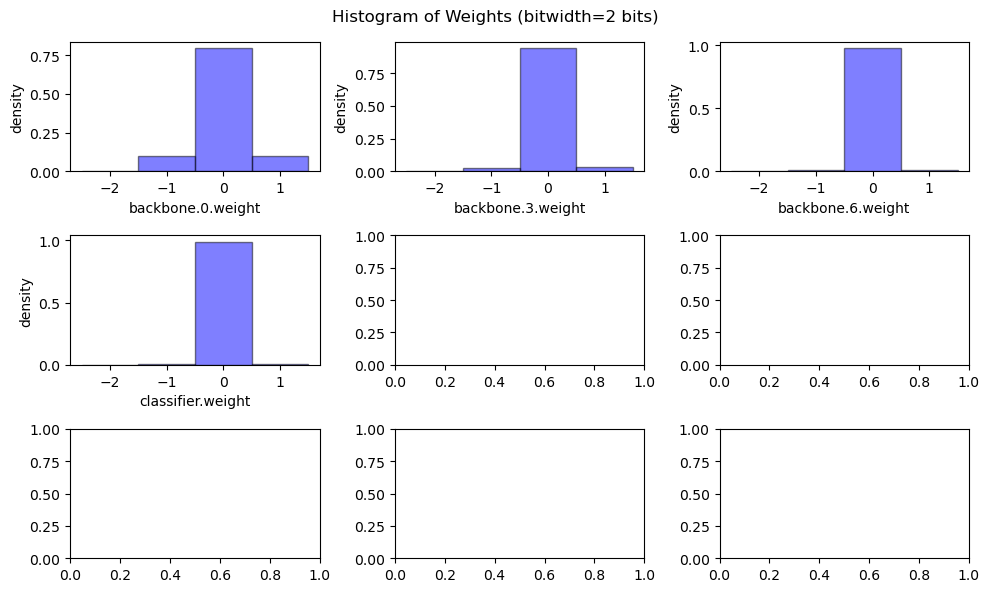

In [19]:
@torch.no_grad()
def peek_scale_quantization():
    for bitwidth in [8, 4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, _ = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_scale_quantization()

In [20]:
def quantized_linear(input, weight, bias, 
                    bias_shift, out_shift,
                    bitwidth=8):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    if bias is not None:
        bias = 2.**bias_shift + bias
        # bias = torch.bitwise_left_shift(bias, bias_shift) #+ NN_ROUND(out_shift)
    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias.to(torch.int32))
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())
    output = output.float().view(1, -1) 
    # >> output shift
    output = output / (2.**out_shift)
    # output = torch.bitwise_right_shift(output, out_shift)
    output = output.round().clamp(*get_quantized_range(bitwidth)).to(torch.int8)
    return output

In [21]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)
    #Weight
    quantized_weight, weight_scale, fw = \
        scale_quantize_feature(weight, bitwidth)
        # linear_quantize_weight_per_channel(weight, bitwidth)
    #In/Out Activation
    quantized_input, input_scale, fi = \
        scale_quantize_feature(input, bitwidth)
    quantized_output, output_scale, fo = \
        scale_quantize_feature(output, bitwidth)
    #Bias
    quantized_bias, bias_scale, fb = \
        scale_quantize_feature(bias, weight_scale, input_scale)
    bias_shift = (fw + fi) - fb
    out_shift = (fw + fi) - fo
    _calc_quantized_output = quantized_linear(quantized_input, quantized_weight, quantized_bias,
                                            bias_shift, out_shift, bitwidth)

    reconstructed_weight = (quantized_weight.float()) * 1./weight_scale
    reconstructed_input = (quantized_input.float()) * 1./input_scale
    reconstructed_bias = (quantized_bias.float()) * 1./bias_scale
    reconstructed_calc_output = (calc_quantized_output.float()) * 1./output_scale

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


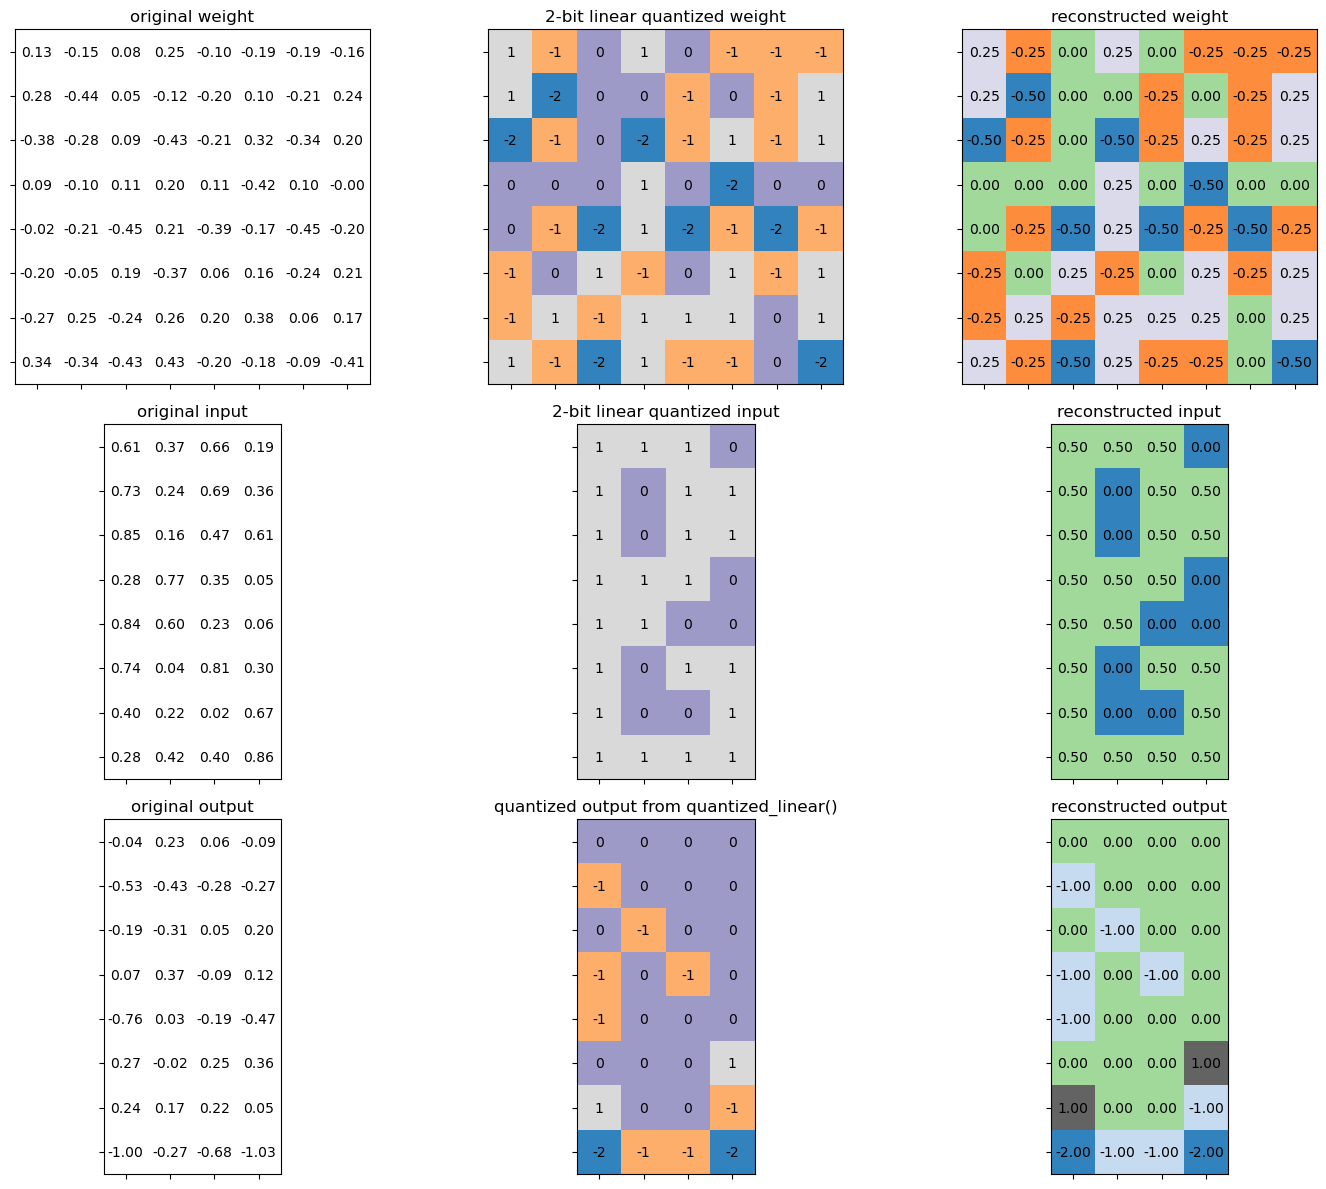

In [22]:
test_quantized_fc()

In [23]:
def quantized_conv2d(input, weight, bias,
                    bias_shift, out_shift,
                    stride, padding, dilation, groups,
                    bitwidth=8):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', 0)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)

    if bias is not None:
        bias = torch.bitwise_left_shift(bias, bias_shift) + NN_ROUND(out_shift)
        output = output + bias.view(1, -1, 1, 1)#.expand_as(output)

    # >> output shift
    output = torch.bitwise_right_shift(output, out_shift).float()
    output = output.round().clamp(*get_quantized_range(bitwidth)).to(torch.int8)
    return output

In [24]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  fuse the batchnorm into conv layers
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  the accuracy will remain the same after fusion
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

Before conv-bn fusion: backbone length 9
After conv-bn fusion: backbone length 9


Accuracy of the fused model=78.20%


In [25]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()


In [26]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias, 
                fi, fw, fo, fb,
                stride, padding, dilation, groups,
                bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)
        self.bias_shift = (fi + fw - fb)
        self.out_shift = (fi + fw - fo)

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.bitwidth = bitwidth

    def forward(self, x):
        # print(x.shape)
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.bias_shift, self.out_shift,
            self.stride, self.padding, self.dilation, self.groups,
            bitwidth=self.bitwidth,
            )
        
class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias, 
                fi, fw, fo, fb,
                bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)
        self.bias_shift = (fi + fw - fb)
        self.out_shift = (fi + fw - fo)
        self.bitwidth = bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias, 
            self.bias_shift, self.out_shift,
            bitwidth=self.bitwidth
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8 
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'
        
        input_scale, fi = scale_quantize(input_activation[conv_name], feature_bitwidth)
        output_scale, fo = scale_quantize(output_activation[relu_name], feature_bitwidth)
        quantized_weight, fw = scale_quantize(conv.weight.data, weight_bitwidth)
        quantized_bias, fb = scale_quantize(conv.bias.data, weight_bitwidth)
        
        quantized_conv = QuantizedConv2d(
            quantized_weight, quantized_bias,
            fi=fi, fw=fw, fo=fo, fb=fb,
            stride= conv.stride, 
            padding= conv.padding,
            dilation = conv.dilation, 
            groups= conv.groups,
            bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride,
            padding=quantized_model.backbone[ptr].padding
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, fi = scale_quantize(
        input_activation[fc_name], feature_bitwidth)
output_scale, fo = scale_quantize(
        output_activation[fc_name], feature_bitwidth)
quantized_weight, fw = scale_quantize(fc.weight.data, weight_bitwidth)
quantized_bias, fb = scale_quantize(fc.bias.data, weight_bitwidth)


quantized_model.classifier = QuantizedLinear(
    quantized_weight, quantized_bias,
    fi = fi, fw = fw, fo = fo, fb = fb,
    bitwidth=weight_bitwidth
)

In [27]:
quantized_weight.shape, quantized_bias.shape

(torch.Size([10, 1024]), torch.Size([10]))

In [28]:
print(quantized_model)


LeNet(
  (backbone): Sequential(
    (0): QuantizedConv2d()
    (1): QuantizedMaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): QuantizedConv2d()
    (3): QuantizedMaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): QuantizedConv2d()
    (5): QuantizedMaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): QuantizedLinear()
)


In [29]:
# image_size = 32
# transforms = {"test": Compose([ToTensor()])}
# dataset = {}
# for split in ["test"]:
#     dataset[split] = CIFAR10(
#         root="data/cifar10",
#         train="test",
#         download=True,
#         transform=transforms[split],
#     )
# dataloader = {}
# for split in ['test']:
#     dataloader[split] = DataLoader(
#         dataset[split],
#         batch_size=32,
#         shuffle=False,
#         num_workers=0,
#         pin_memory=True,
#     )

In [30]:

def fracbits(x):
    return 7 - int(np.ceil(np.log2(np.abs(x).max())))
def extra_preprocess(x):
#     x = x - x.mean(dim=(1, 2), keepdim=True)
#     x = x * (2. ** 7)
#     return x.clamp(-128, 127).to(torch.int8)
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)


int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                            extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")



int8 model has accuracy=4.62%
